In [1]:
# We recommend running our code on a GPU with more than 8GB of memory for satisfactory acceleration
# To run the jupyter notebook, the following libraries are required
# pandas 
# torch
# opencv-python  
# pykeops   please reffer to http://www.kernel-operations.io/keops 

In [15]:
import os.path
import sys
sys.path.append('/home/chenyidong/keops')
import numpy as np
import torch
from random import choices
import imageio
from pykeops.torch import LazyTensor
from pykeops.torch.cluster import grid_cluster
import pandas as pd
import numpy as np
from pykeops.torch.cluster import cluster_ranges_centroids
from pykeops.torch import generic_argmin
from pykeops.torch import generic_argmin
from pykeops.torch import generic_sum,generic_logsumexp,generic_argmin
from pykeops.torch import generic_argmin
from pykeops.torch import generic_sum,generic_logsumexp,generic_argmin
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.DoubleTensor if use_cuda else torch.FloatTensor

from mytools import load_image,RGB_cloud,get_measure,combine_measure,squared_distances,sort_clusters,progate
from SparseSinkhorn import  sinkhorn_on_log_domain_GPU_keops
 

In [17]:

%matplotlib inline
import cv2 as cv
from matplotlib import pyplot as plt

 
flies =["automn10.jpg","winter2.jpg"]
i=0
j=1
X_i = RGB_cloud(flies[i],sampling=-1,dtype=dtype)
Y_j = RGB_cloud(flies[j],sampling=-1,dtype=dtype) 

# 
eps = 0.025  # Size of our square bins 
x_labels_ = grid_cluster(X_i, eps)  # class labels
eps = 0.03  # Size of our square bins 
y_labels_ = grid_cluster(Y_j, eps)  # class labels


# Compute one range and centroid per class:
x_ranges, x_centroids, _ = cluster_ranges_centroids(X_i, x_labels_)
y_ranges, y_centroids, _ = cluster_ranges_centroids(Y_j, y_labels_)
x, x_labels,orginalx = sort_clusters(X_i, x_labels_)
y, y_labels,orginaly = sort_clusters(Y_j, y_labels_)


measure = np.ones((len(x),1))/x.shape[0]
mux = combine_measure(x_labels,measure)
muy = combine_measure(y_labels,measure)

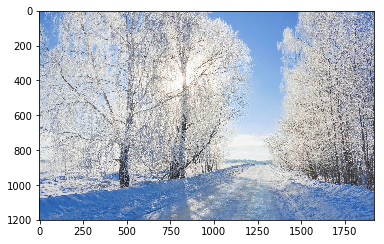

In [18]:
xx = np.array(Y_j.reshape((1200,1920,3)).cpu())
plt.imshow(xx)

In [19]:
print(x_centroids.shape)
print(y_centroids.shape)

torch.Size([22586, 3])
torch.Size([2622, 3])


In [20]:
# solve the first layer
reg = 1e-6
debug = 0
f,g,regk = sinkhorn_on_log_domain_GPU_keops(mux, muy, x_centroids, y_centroids , reg,  epsilon0 = 1e3, numItermax=20,stopThr=1e-9,debug=debug,ranges = None)

tensor([1.], device='cuda:0', dtype=torch.float64)
tensor([2.], device='cuda:0', dtype=torch.float64)
tensor([3.], device='cuda:0', dtype=torch.float64)
tensor([4.], device='cuda:0', dtype=torch.float64)
tensor([5.], device='cuda:0', dtype=torch.float64)
tensor([6.], device='cuda:0', dtype=torch.float64)
tensor([7.], device='cuda:0', dtype=torch.float64)
tensor([8.], device='cuda:0', dtype=torch.float64)
tensor([9.], device='cuda:0', dtype=torch.float64)
tensor([10.], device='cuda:0', dtype=torch.float64)
tensor([11.], device='cuda:0', dtype=torch.float64)
tensor([12.], device='cuda:0', dtype=torch.float64)
tensor([13.], device='cuda:0', dtype=torch.float64)
tensor([14.], device='cuda:0', dtype=torch.float64)
tensor([15.], device='cuda:0', dtype=torch.float64)
tensor([16.], device='cuda:0', dtype=torch.float64)
tensor([17.], device='cuda:0', dtype=torch.float64)
tensor([18.], device='cuda:0', dtype=torch.float64)
tensor([19.], device='cuda:0', dtype=torch.float64)
tensor([20.], device=

In [21]:
from pykeops.torch.cluster import cluster_ranges_centroids
from pykeops.torch.cluster import sort_clusters
from pykeops.torch.cluster import from_matrix

torch.cuda.empty_cache()
D =  -torch.sum((x_centroids[:, None, :] - y_centroids[None, :, :]) ** 2, 2) + f + g.t()
#D =   -(D - f - g.t())   
thetalist = torch.logspace(-1,-12,steps=500)
for theta in  thetalist:
    #print(theta)
    #theta  = 1e-9
    theta = torch.as_tensor(theta).type(dtype)
    
    keep = D > torch.log(theta)* regk
    ranges_ij   = from_matrix(x_ranges, y_ranges, keep)
 
    a = D[keep]


    if torch.all(torch.sum(keep,dim=0)>0) and torch.all(torch.sum(keep,dim=1)>0):
        break
areas = (x_ranges[:, 1] - x_ranges[:, 0])[:, None] * (y_ranges[:, 1] - y_ranges[:, 0])[
    None, :
]
total_area = torch.sum(areas)  # should be equal to N*M
sparse_area = torch.sum(areas[keep])
print(
    "We keep {:.3e}/{:.3e} = {:.3f}% of the original kernel matrix.".format(
        sparse_area, total_area, float(100 * sparse_area / total_area)
    )
)
print("") 

We keep 2.870e+10/5.308e+12 = 0.541% of the original kernel matrix.



In [22]:
# progagation 
fnew = progate(f,x_labels)
gnew = progate(g,y_labels)
fnew_ = LazyTensor(fnew[:, None])
gnew_ = LazyTensor(gnew[:, None])
reg = 0.01
measurex = torch.as_tensor(measure).type(dtype)
measurey = torch.as_tensor(measure).type(dtype)
debug = 0

fall,gall,regk = sinkhorn_on_log_domain_GPU_keops(measurex, measurey, x, y, reg,
                                                  epsilon0 = 1e3, numItermax=20,stopThr=1e-9,ranges = ranges_ij ,
                                                   warmf=fnew,warmg=gnew, debug=debug)

tensor([1.], device='cuda:0', dtype=torch.float64)
tensor([2.], device='cuda:0', dtype=torch.float64)
tensor([3.], device='cuda:0', dtype=torch.float64)
tensor([4.], device='cuda:0', dtype=torch.float64)
tensor([5.], device='cuda:0', dtype=torch.float64)
tensor([6.], device='cuda:0', dtype=torch.float64)
tensor([7.], device='cuda:0', dtype=torch.float64)
tensor([8.], device='cuda:0', dtype=torch.float64)
tensor([9.], device='cuda:0', dtype=torch.float64)


In [23]:
def generate_the_optimal_transport_map(mu, nv, x,y,finit,ginit,   epsilon0 = 1e6,ranges = None):
    
    x_i, y_j = LazyTensor(x[:, None, :]), LazyTensor(y[:, None, :])
    
    logss = generic_argmin(
       '(  (SqNorm2(x-y) - f - g))  ', # Formula
        
        'a = Vi(1)',           
        'x = Vi(3)',           

        'y = Vj(3)',  'f = Vi(1)', 
        
        'g = Vj(1)',
        
        dtype  = 'float64'  )          

    K =   logss(x,y,finit,ginit,ranges = ranges)

 
    return  K


map_x_to_y = generate_the_optimal_transport_map(measurex, measurey, x, y ,fall,gall,ranges = ranges_ij)

#regk1 = 1.0/regk
#map_x_to_y2 = generate_the_optimal_transport_map2(measurex, measurey, x, y ,fall,gall,epsilon0 = regk1,ranges = ranges_ij)

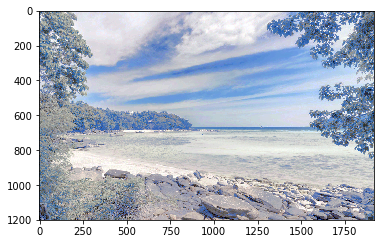

In [24]:
def show_sorted_image(orginal,xdata,sizex,sizey):
    data = pd.DataFrame()
    data['index'] = np.array(orginal.cpu())
    temp =  np.array(xdata.cpu()) 
    data['r1'] = temp[:,0]
    data['r2'] = temp[:,1]
    data['r3'] = temp[:,2]
    d = torch.tensor(np.array(data.sort_values('index')))
    need = (
        torch.stack((d[:,1], d[:,2], d[:,3]))
    .t()
    .contiguous()
    )
    return np.array(need.reshape((sizex,sizey,3)).cpu())
data = pd.DataFrame()
temp =  np.array(y.cpu()) 
data['r1'] = temp[:,0]
data['r2'] = temp[:,1]
data['r3'] = temp[:,2]



xmap = np.array(map_x_to_y.cpu()).squeeze(1)
datax = data.iloc[xmap] #OK that's it!!!!
d = torch.tensor(np.array(datax))
mapped_image = show_sorted_image(orginalx,d,1200,1920)
                    
plt.imshow(mapped_image)
plt.imsave('hh.jpg',mapped_image)

In [10]:
regk1 = 1.0/regk
map_x_to_y2 = generate_the_optimal_transport_map2(measurex, measurey, x, y ,fall,gall,epsilon0 = regk1,ranges = ranges_ij)

In [25]:
def show_sorted_image2(orginal,xdata,sizex,sizey):
    data = pd.DataFrame()
    data['index'] = np.array(orginal.cpu())
    temp =  np.array(xdata.cpu()) 
    data['r1'] = temp[:,0]
    data['r2'] = temp[:,1]
    data['r3'] = temp[:,2]
    d = torch.tensor(np.array(data.sort_values('index')))
    need = (
        torch.stack((d[:,1], d[:,2], d[:,3]))
    .t()
    .contiguous()
    )
    return np.array(need.reshape((sizex,sizey,3)).cpu())
data = pd.DataFrame()

temp =  np.array(y.cpu()) 
data['r1'] = temp[:,0]
data['r2'] = temp[:,1]
data['r3'] = temp[:,2]

data2 = pd.DataFrame()
 
d1 =   (map_x_to_y2[0].cpu())
d2 =   (map_x_to_y2[1].cpu())
d3 =   (map_x_to_y2[2].cpu())

d = np.zeros((2304000,3,1))
d[:,0]=d1
d[:,1]=d2
d[:,2]=d3
d = torch.tensor(d)
 
mapped_image = show_sorted_image(orginalx,d,1200,1920)
                    
plt.imshow(mapped_image)
plt.imsave('hh.jpg',mapped_image)
 

NameError: name 'map_x_to_y2' is not defined